## Model Selection, Underfitting and Overfitting

### 1.) Statistical Learning Theory
- In supervised learning, we assuem both training and testing data are drawn **independently** from **idential** distributions.
- This is commonly called the **i.i.d assumption**
- We can say thats samples our data has no memory.
- Most of real work data, we can get away with minor violations of the i.i.d. assumption but models will still work remarkably well.
- Many of techniques in deep learning are heuristics and tricks aimed at guarding against overfitting.

### 2.) Model Complexity
- Model with more parameters might be considered more complex.
- Model that can take wider range of value might be more complex.
- In neural network, model with more iteratiosn training considered as more complex. (Early stopping can help on this)

### 3.) Some few factors to keep considered
- Number of tunale paramerters (Degrees of Freedom) : Higher tunable parameters lead to more susceptible to overfitting.
- Value taken by parameters : More wider range of input values, model can be more susceptible to overfitting.
- Number of training examples : Small dataset trend to make model overfitting.

### Polynomial Regression

First we need data. Given $x$, we will [**use the following cubic polynomial to generate the labels**] on training and test data:

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**

The noise term $\epsilon$ obeys a normal distribution
with a mean of 0 and a standard deviation of 0.1.
For optimization, we typically want to avoid
very large values of gradients or losses.
This is why the *features*
are rescaled from $x^i$ to $\frac{x^i}{i!}$.
It allows us to avoid very large values for large exponents $i$.
We will synthesize 100 samples each for the training set and test set.

In [1]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [40]:
### Synthesize 100 samples data
max_degree = 20 # Maximum degree of the polynomail
n_train, n_test = 100, 100 # Training and test dataset size
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size = (n_train + n_test, 1)) # Total 200 records
np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

In [50]:
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n) = (n-1)! is the fraction of our polynomial for normalized

# Shape of 'labels' : ('n_train'  + 'n_test', )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1, size = labels.shape)

In [75]:
true_w, features, poly_features, labels = [tf.constant(x, dtype = tf.float32) for x in [true_w, features, poly_features, labels]]

In [78]:
  features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 1.4451367],
        [-0.540931 ]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.0000000e+00,  1.4451367e+00,  5.2210498e-01,  8.3834782e-02,
          7.5720446e-03,  4.3770557e-04,  1.7570675e-05,  5.1820467e-07,
          1.1701196e-08,  2.0876328e-10,  3.0169148e-12,  3.6031853e-14,
          3.6160382e-16,  3.0921120e-18,  2.2798594e-20,  1.4643148e-22,
          8.2661520e-25,  4.1334667e-27,  1.8436496e-29,  7.3804030e-32],
        [ 1.0000000e+00, -5.4093099e-01,  7.3151588e-02, -4.3966626e-03,
          1.4864320e-04, -3.2162286e-06,  4.8326605e-08, -5.3349714e-10,
          4.5091431e-12, -3.0112780e-14,  1.6288937e-16, -7.2819760e-19,
          2.7354491e-21, -8.7555577e-24,  2.4164044e-26, -5.8093691e-29,
          1.2275266e-31, -2.2976027e-34,  3.8359400e-37, -5.7478601e-40]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5.461142 , 4.1161814], dtype=

### Training and Testing the Model

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator.

    Defined in :numref:`sec_linear_concise`"""
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

In [79]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3.

    Defined in :numref:`sec_softmax_scratch`"""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [80]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):

    # Loss Functions      
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    
    # Model
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))

    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    # Trainer
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)

    # Visualization on each epochs
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
                            
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

### Third-Order Polynomial

weight: [[ 4.974594    1.5622315  -3.3146229   0.18815197]]


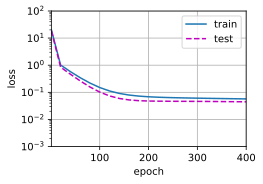

In [81]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:]) 

### Linear Function

weight: [[4.3028984 1.497481 ]]


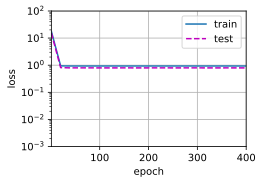

In [82]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### Higher Order Function (Max Degree = 20)

weight: [[ 4.9880624   1.4334347  -3.3753054   2.1514328   0.07563999 -0.4491483
   0.34669858 -0.1449596   0.34373575 -0.30821168 -0.3640799  -0.10638851
   0.26844412 -0.38046244 -0.20574847  0.35355282 -0.23073909 -0.41612172
   0.06528473  0.27829194]]


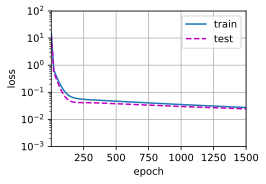

In [83]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)